# Cogs 118C Final Project

## Anand Mysorekar, Leo Fleury, & Ava Rubin

# Loading Data

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy import signal

In [219]:
# Acessing AD & control 
processed_Control = np.load("Control_EEG_sub_037_processed.npy")
processed_AD = np.load("AD_EEG_sub_001_processed.npy")

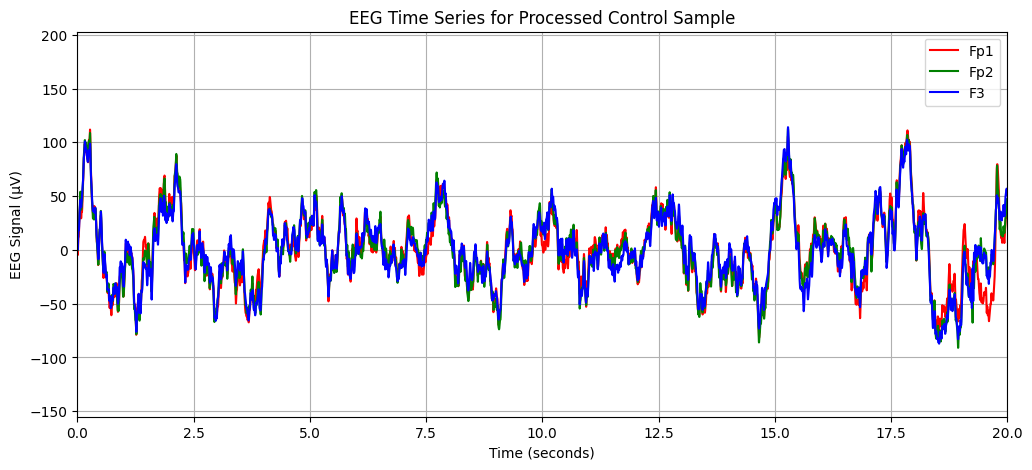

In [220]:
fs = 500  # Sampling rate (Hz)
num_samples = processed_Control.shape[1]  # 10000 samples

time = np.linspace(0, num_samples / fs, num_samples)

channels = ['Fp1', 'Fp2', 'F3']
colors = ['r', 'g', 'b']  # Red, Green, Blue

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, processed_Control[i, :], label=channels[i], color=colors[i])

# Formatting
plt.xlim(0,20)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for Processed Control Sample")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

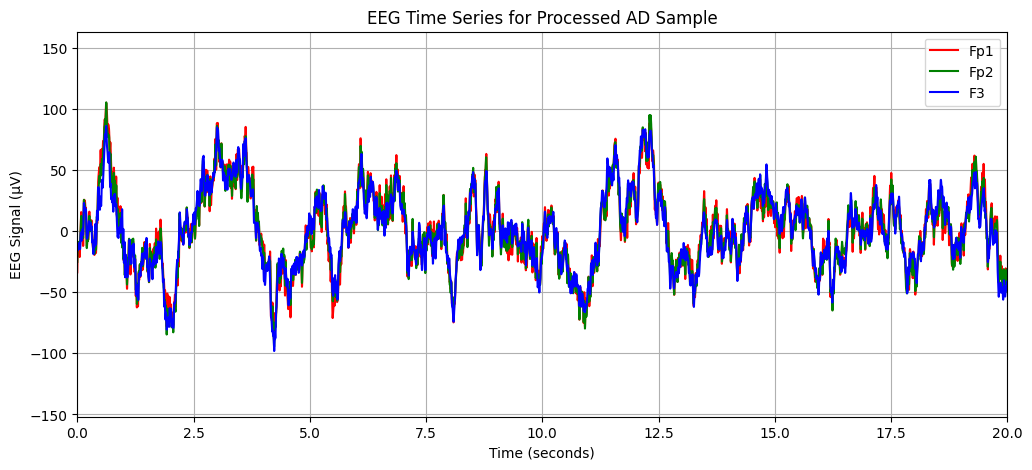

In [221]:
fs = 500  # Sampling rate (Hz)
num_samples = processed_AD.shape[1]  # 10000 samples

time = np.linspace(0, num_samples / fs, num_samples)

channels = ['Fp1', 'Fp2', 'F3']
colors = ['r', 'g', 'b']  # Red, Green, Blue

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.plot(time, processed_AD[i, :], label=channels[i], color=colors[i])

# Formatting
plt.xlim(0,20)
plt.xlabel("Time (seconds)")
plt.ylabel("EEG Signal (µV)")
plt.title("EEG Time Series for Processed AD Sample")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

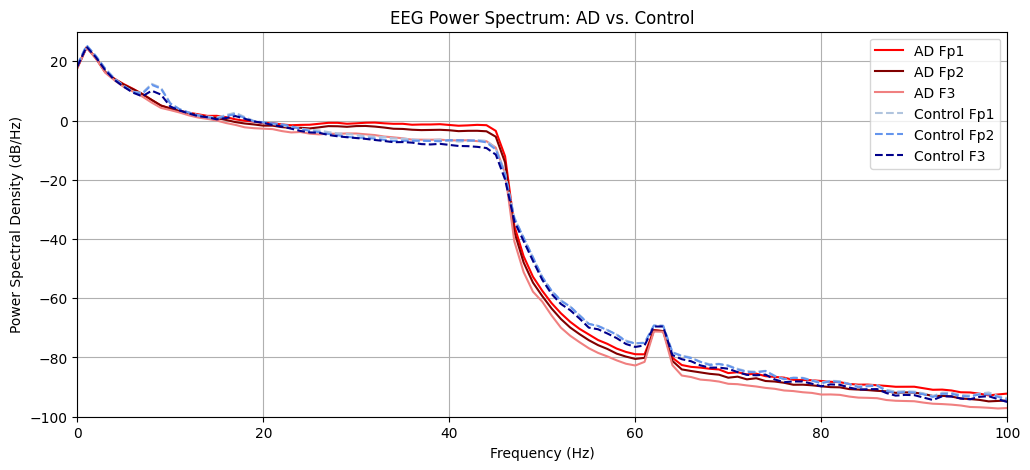

In [238]:
def plot_psd(signal, fs,condition, line_style,color):
    """Plots absolute power in theta/gamma bands between control and AD groups for all subjects."""
    freqs, psd = welch(signal, fs=fs, window='hann', nperseg=500, noverlap=250, scaling='density') # We use Welches
     # Convert to dB  and plot
    plt.plot(freqs, 10 * np.log10(psd), label=condition, linestyle=line_style, color=color)
    plt.xlim(0, 100)  # Keep in range
    plt.ylim(-100, 30)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.title('EEG Power Spectrum: AD vs. Control')
    plt.grid(True)

# Parameters 
fs = 500             # Sampling rate
theta_band = (4, 8)  # Theta frequency range
gamma_band = (30, 100) # Gamma frequency range 

# Plot PSD for AD and Control groups
plt.figure(figsize=(12, 5))

AD_color = ['r', 'maroon', 'lightcoral']
control_color = ['lightsteelblue', 'cornflowerblue', 'darkblue']

# Loop through AD group
for i in range(processed_AD.shape[0]):
    plot_psd(processed_AD[i, :], fs, condition=f"AD {channels[i]}", line_style='-', color=AD_color[i])

# Loop through Control group
for i in range(processed_Control.shape[0]):
    plot_psd(processed_Control[i, :], fs, condition=f"Control {channels[i]}", line_style='--', color=control_color[i])

plt.legend()  # Add legend to distinguish AD and Control
plt.show()

In [223]:
# bandass filtering for theta and gamma 

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

fs = 500             # Sampling rate
theta_band = (4, 8)  # Theta frequency range
gamma_band = (30, 100) # Gamma frequency range

AD_filtered = []
for i in range(processed_AD.shape[0]):  # Loop over channels
    theta_data = bandpass_filter(processed_AD[i, :], theta_band[0], theta_band[1], fs)
    gamma_data = bandpass_filter(processed_AD[i, :], gamma_band[0], gamma_band[1], fs)
    AD_filtered.append((channels[i], theta_data, gamma_data))

# Apply bandpass filtering for Control group
control_filtered = []
for i in range(processed_Control.shape[0]):  # Loop over channels
    theta_data = bandpass_filter(processed_Control[i, :], theta_band[0], theta_band[1], fs)
    gamma_data = bandpass_filter(processed_Control[i, :], gamma_band[0], gamma_band[1], fs)
    control_filtered.append((channels[i], theta_data, gamma_data))

In [224]:
# Compute band power using np.trapz
def compute_band_power(raw_data, fs, band, nperseg=500):
    """Compute absolute/relative power from raw (unfiltered) data."""
    freqs, psd = welch(raw_data, fs=fs, nperseg=nperseg)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    abs_power = np.trapz(psd[idx], freqs[idx])
    total_power = np.trapz(psd, freqs)  # Total power across all frequencies
    rel_power = abs_power / total_power
    return abs_power, rel_power

# Initialize storage for band power results
results = {
    'AD_theta_abs': [], 'AD_theta_rel': [],
    'AD_gamma_abs': [], 'AD_gamma_rel': [],
    'CTRL_theta_abs': [], 'CTRL_theta_rel': [],
    'CTRL_gamma_abs': [], 'CTRL_gamma_rel': []
}

# Process AD group using pre-filtered data
for i in range(processed_AD.shape[0]):
    theta_abs, theta_rel = compute_band_power(processed_AD[i, :], fs, theta_band)
    gamma_abs, gamma_rel = compute_band_power(processed_AD[i, :], fs, gamma_band)
    results['AD_theta_abs'].append(theta_abs)
    results['AD_theta_rel'].append(theta_rel)
    results['AD_gamma_abs'].append(gamma_abs)
    results['AD_gamma_rel'].append(gamma_rel)

# Process Control group using pre-filtered data
for i in range(processed_Control.shape[0]):
    theta_abs, theta_rel = compute_band_power(processed_Control[i, :], fs, theta_band)
    gamma_abs, gamma_rel = compute_band_power(processed_Control[i,:], fs, theta_band)
    results['CTRL_theta_abs'].append(theta_abs)
    results['CTRL_theta_rel'].append(theta_rel)
    results['CTRL_gamma_abs'].append(gamma_abs)
    results['CTRL_gamma_rel'].append(gamma_rel)

results

{'AD_theta_abs': [51.95177048117853, 50.49131664656086, 43.10376141417811],
 'AD_theta_rel': [0.0858108510823727, 0.08432938315916888, 0.0763744706100916],
 'AD_gamma_abs': [11.414519509934907, 7.751466737177737, 3.752735953584939],
 'AD_gamma_rel': [0.0188538258614058,
  0.01294631338494791,
  0.006649378439168685],
 'CTRL_theta_abs': [54.62182256188003, 52.79019487247955, 45.93840185501731],
 'CTRL_theta_rel': [0.07750862942650562,
  0.07484707492199535,
  0.07367741751441649],
 'CTRL_gamma_abs': [54.62182256188003, 52.79019487247955, 45.93840185501731],
 'CTRL_gamma_rel': [0.07750862942650562,
  0.07484707492199535,
  0.07367741751441649]}

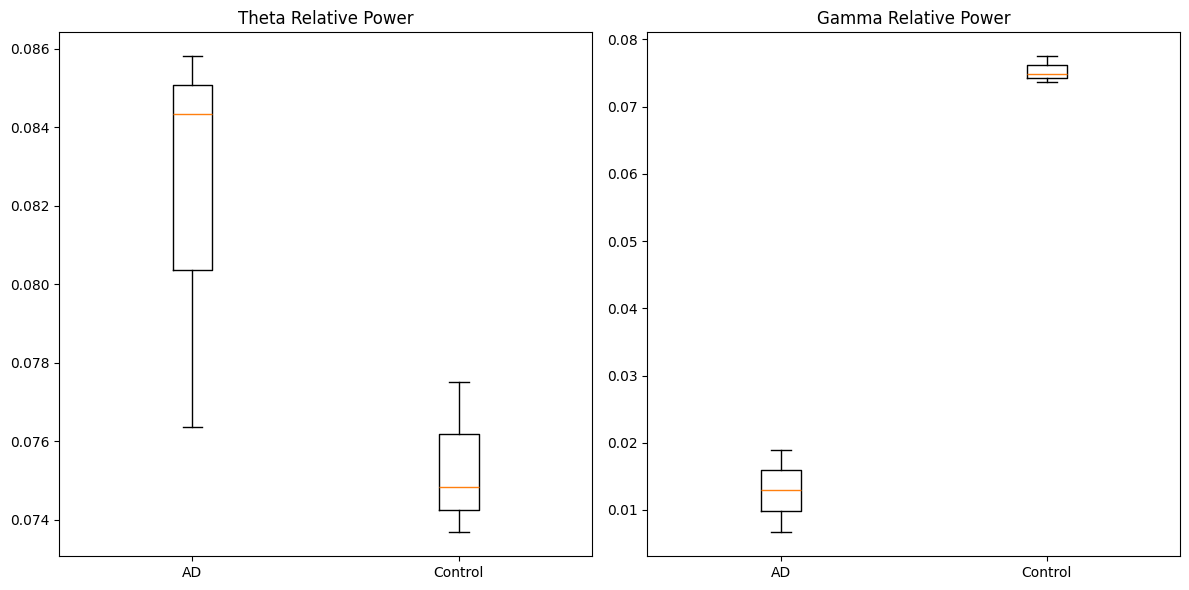

AD subject: Theta = 8.22%, Gamma = 7.53%
AD subject: Theta = 8.22%, Gamma = 7.53%


In [225]:
# data for absolute value is normal or homoscedastic (equal variance) so ahve to use Mann-whitney
# data is not paired (independent) (theta data for AD and control come from different patients) 
# so cant do theta_data - theta data AD_Fp1 – Control_Fp1 and see if not equal to 0 

# # Statistical testing
# def compare_groups(ad_data, ctrl_data, name):
#     stat, p = mannwhitneyu(ad_data, ctrl_data)
#     print(f"{name}: U={stat:.1f}, p={p:.4f}")
#     return p

# p_values = [
#     compare_groups(results['AD_theta_abs'], results['CTRL_theta_abs'], "Theta Absolute Power"),
#     compare_groups(results['AD_theta_rel'], results['CTRL_theta_rel'], "Theta Relative Power"),
#     compare_groups(results['AD_gamma_abs'], results['CTRL_gamma_abs'], "Gamma Absolute Power"),
#     compare_groups(results['AD_gamma_rel'], results['CTRL_gamma_rel'], "Gamma Relative Power")
# ]

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.boxplot([results['AD_theta_rel'], results['CTRL_theta_rel']])
plt.title('Theta Relative Power')
plt.xticks([1, 2], ['AD', 'Control'])

plt.subplot(122)
plt.boxplot([results['AD_gamma_rel'], results['CTRL_gamma_rel']])
plt.title('Gamma Relative Power')
plt.xticks([1, 2], ['AD', 'Control'])
plt.tight_layout()
plt.show()

# Averaging Gamma and Theta
ad_theta_avg = np.mean(results['AD_theta_rel'])
ad_gamma_avg = np.mean(results['AD_gamma_rel'])
ctrl_theta_avg = np.mean(results['CTRL_theta_rel'])
ctrl_gamma_avg = np.mean(results['CTRL_gamma_rel'])

print(f'AD subject: Theta = {(ad_theta_avg * 100):.2f}%, Gamma = {(ctrl_theta_avg * 100):.2f}%')
print(f'AD subject: Theta = {(ad_theta_avg * 100):.2f}%, Gamma = {(ctrl_theta_avg * 100):.2f}%')

In [226]:
# def plot_subject_power(results_ad, results_ctrl, band_name):
#     plt.figure(figsize=(10, 4))
#     # AD Subject
#     plt.subplot(121)
#     plt.bar(channels, results_ad, color='red', alpha=0.7)
#     plt.title(f'AD Subject: {band_name} Relative Power')
#     plt.ylabel('Power')
#     # Control Subject
#     plt.subplot(122)
#     plt.bar(channels, results_ctrl, color='blue', alpha=0.7)
#     plt.title(f'Control Subject: {band_name} Relative Power')
#     plt.tight_layout()
#     plt.show()

# # Plot theta/gamma relative power for AD vs. Control
# plot_subject_power(results['AD_theta_rel'], results['CTRL_theta_rel'], 'Theta')
# plot_subject_power(results['AD_gamma_rel'], results['CTRL_gamma_rel'], 'Gamma')

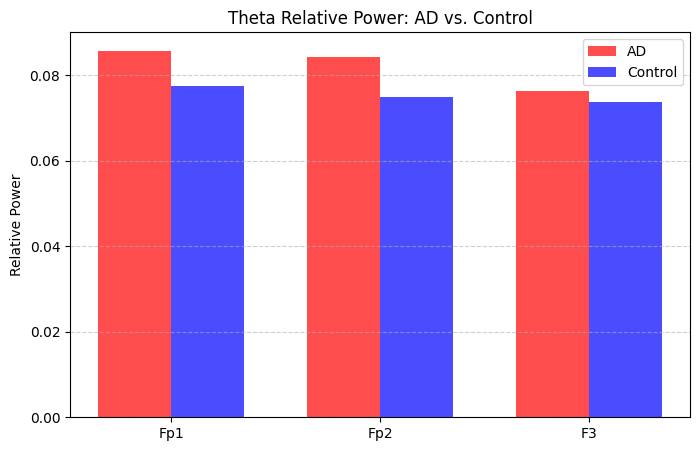

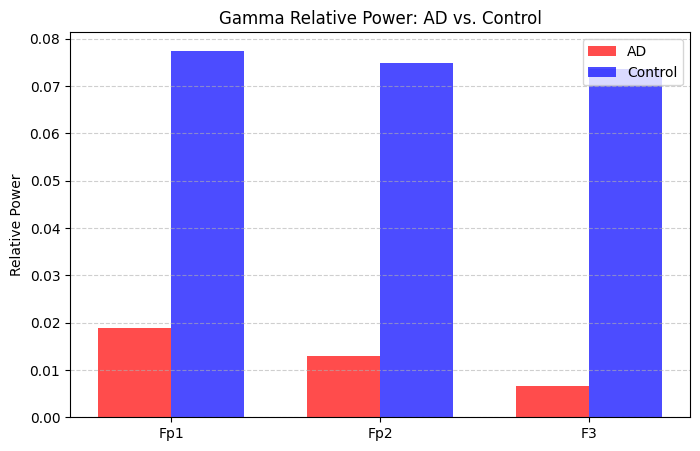

In [227]:
def plot_grouped_power(results_ad, results_ctrl, band_name):
    plt.figure(figsize=(8, 5))
    
    # Define bar width and positions
    x = np.arange(len(channels))  # X positions for the bars
    width = 0.35  # Width of bars

    # Plot bars for AD and Control
    plt.bar(x - width/2, results_ad, width, color='red', alpha=0.7, label='AD')
    plt.bar(x + width/2, results_ctrl, width, color='blue', alpha=0.7, label='Control')

    # Formatting
    plt.xticks(ticks=x, labels=channels)  # Set channel labels on x-axis
    plt.ylabel('Relative Power')
    plt.title(f'{band_name} Relative Power: AD vs. Control')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

# Generate grouped bar plots for Theta and Gamma bands
plot_grouped_power(results['AD_theta_rel'], results['CTRL_theta_rel'], 'Theta')
plot_grouped_power(results['AD_gamma_rel'], results['CTRL_gamma_rel'], 'Gamma')


In [228]:
processed_AD.shape

(3, 150000)